# FSSP DQN
___

## Introduction : 
In this notebook, we explore the application of reinforcement learning to the Flow Shop Scheduling Problem (FSSP), a well-known combinatorial optimization challenge in operations research. The goal is to efficiently schedule a series of jobs across multiple machines with the objective of minimizing the total processing time, known as the "makespan". Using Deep Q-Networks (DQN), we aim to dynamically optimize the parameters of various metaheuristic algorithms, such as Genetic Algorithm, Simulated Annealing, and Tabu Search, to improve solution quality. This approach not only demonstrates the potential of reinforcement learning in complex optimization tasks but also serves as a bridge between traditional heuristic techniques and modern AI strategies.

In [1]:
# import the necessary packages

import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import gym   # open ai gym RL space
from gym import spaces

# import the necessary utils functions
from utils.benchmark import benchmarks
from utils.big_benchmark import big_benchmarks

# import drawing tools
import matplotlib.pyplot as plt 


In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

## Envirement

The FSSPEnvironment class is a custom simulation environment based on the OpenAI Gym framework, designed for the Flow Shop Scheduling Problem (FSSP). It enables the application of various metaheuristics with tunable hyperparameters through a reinforcement learning agent to minimize the total processing time of jobs across multiple machines.

In [3]:

class FSSPEnvironment(gym.Env):
    def __init__(self, jobs, machines):
        super(FSSPEnvironment, self).__init__()
        self.jobs = jobs
        self.machines = machines
        self.n_jobs = len(jobs)
        self.n_machines = len(machines)

        # Update: 3 metaheuristics x 60 parameter configurations each
        self.action_space = spaces.Discrete(3 * 60)
        self.observation_space = spaces.Box(low=0, high=1, shape=(self.n_jobs, self.n_machines), dtype=np.float32)

        self.state = np.zeros((self.n_jobs, self.n_machines))

    def reset(self):
        self.state = np.zeros((self.n_jobs, self.n_machines))
        return self.state

    def step(self, action):
        metaheuristic, hyperparameters = self.decode_action(action)
        solution = self.apply_metaheuristic(metaheuristic, hyperparameters)

        makespan = self.calculate_makespan(self.jobs, list(solution))
        reward = -makespan

        self.state = self.update_state(solution)
        done = True  # Consider parameterizing 'done' for episodes longer than one step if needed

        return self.state, reward, done, {"metaheuristic": metaheuristic, "hyperparameters": hyperparameters, "makespan": makespan}

    def decode_action(self, action):
        metaheuristic = action // 60
        hyperparameter_set = action % 60

        hyperparameters = self.get_hyperparameters(metaheuristic, hyperparameter_set)
        return metaheuristic, hyperparameters

    def get_hyperparameters(self, metaheuristic, set_number):
        if metaheuristic == 0:  # Genetic Algorithm
            return {
                "population_size": 50 + (set_number % 5) * 10,
                "mutation_rate": 0.05 + (set_number % 4) * 0.01,
                "crossover_rate": 0.6 + (set_number // 5) * 0.05,
                "elitism_rate": 0.05 * (set_number % 4),
                "selection_type": "tournament" if set_number % 2 == 0 else "roulette"
            }
        elif metaheuristic == 1:  # Simulated Annealing
            return {
                "initial_temperature": 100 + set_number * 10,
                "cooling_rate": 0.85 + (set_number % 5) * 0.01,
                "final_temperature": 0.01 + (set_number // 5) * 0.01,
                "alpha": 0.95 - (set_number % 5) * 0.005,
                "neighborhood_function": "swap" if set_number % 2 == 0 else "insert"
            }
        elif metaheuristic == 2:  # Tabu Search
            return {
                "tabu_list_size": 5 + set_number % 5,
                "max_iterations": 100 + (set_number // 5) * 20,
                "neighborhood_size": 10 + (set_number % 3) * 5,
                "diversification_factor": (set_number % 4) * 0.1,
                "intensification_factor": (set_number % 4) * 0.1
            }

    def apply_metaheuristic(self, metaheuristic, hyperparameters):
        if metaheuristic == 0:
            return self.genetic_algorithm(hyperparameters)
        elif metaheuristic == 1:
            return self.simulated_annealing(hyperparameters)
        elif metaheuristic == 2:
            return self.tabu_search(hyperparameters)

    def update_state(self, solution):
        return solution

    def calculate_makespan(self, processing_times, sequence):
        n_jobs = len(sequence)
        n_machines = len(processing_times[0])
        end_time = [[0] * (n_machines + 1) for _ in range(n_jobs + 1)]

        for j in range(1, n_jobs + 1):
            for m in range(1, n_machines + 1):
                end_time[j][m] = max(end_time[j][m - 1], end_time[j - 1][m]) + processing_times[sequence[j - 1]][m - 1]

        return end_time[n_jobs][n_machines]


    def genetic_algorithm(self, hyperparameters):
        population_size = hyperparameters["population_size"]
        mutation_rate = hyperparameters["mutation_rate"]
        crossover_rate = hyperparameters["crossover_rate"]
        generations = 100  # Define the number of generations

        # Initialize population: Array of permutations
        population = [np.random.permutation(self.n_jobs)
                    for _ in range(population_size)]
        best_sequence = None
        best_makespan = float('inf')

        for _ in range(generations):
            # Evaluate population to get fitness values
            fitness = [self.calculate_makespan(
                self.jobs, sequence) for sequence in population]
            # Sort population based on fitness (ascending, because lower makespan is better)
            ranked_population = [x for _, x in sorted(
                zip(fitness, population), key=lambda pair: pair[0])]

            # Start new generation with elitism (optional: carry over some best performers)
            next_generation = ranked_population[:int(
                0.1 * population_size)]  # 10% elitism

            # Crossover
            while len(next_generation) < population_size:
                if np.random.rand() < crossover_rate:
                    # Select parents by index
                    indices = np.random.choice(
                        range(len(ranked_population)//2), 2, replace=False)
                    parent1, parent2 = ranked_population[indices[0]
                                                        ], ranked_population[indices[1]]
                    cut_point = np.random.randint(1, self.n_jobs - 1)
                    child1 = np.concatenate(
                        (parent1[:cut_point], [x for x in parent2 if x not in parent1[:cut_point]]))
                    child2 = np.concatenate(
                        (parent2[:cut_point], [x for x in parent1 if x not in parent2[:cut_point]]))
                    next_generation.extend(
                        [child1, child2][:population_size-len(next_generation)])

            # Mutation
            for individual in next_generation:
                if np.random.rand() < mutation_rate:
                    swap_idx = np.random.choice(
                        range(self.n_jobs), 2, replace=False)
                    individual[swap_idx[0]], individual[swap_idx[1]
                                                        ] = individual[swap_idx[1]], individual[swap_idx[0]]

            population = next_generation  # Replace old population with new

            # Update best solution
            current_best_index = np.argmin(
                [self.calculate_makespan(self.jobs, indiv) for indiv in population])
            current_best_makespan = self.calculate_makespan(
                self.jobs, population[current_best_index])
            if current_best_makespan < best_makespan:
                best_makespan = current_best_makespan
                best_sequence = population[current_best_index]

        return best_sequence

    def simulated_annealing(self, hyperparameters):
        initial_temperature = hyperparameters["initial_temperature"]
        cooling_rate = hyperparameters["cooling_rate"]
        final_temperature = hyperparameters["final_temperature"]
        alpha = hyperparameters["alpha"]
        neighborhood_function = hyperparameters["neighborhood_function"]

        current_sequence = np.random.permutation(self.n_jobs)
        current_makespan = self.calculate_makespan(self.jobs, current_sequence)
        best_sequence = current_sequence
        best_makespan = current_makespan
        temperature = initial_temperature

        while temperature > final_temperature:
            i, j = np.random.randint(0, self.n_jobs, 2)
            if neighborhood_function == "swap":
                new_sequence = current_sequence.copy()
                new_sequence[i], new_sequence[j] = new_sequence[j], new_sequence[i]
            else:  # insert
                new_sequence = np.insert(np.delete(current_sequence, i), j, current_sequence[i])

            new_makespan = self.calculate_makespan(self.jobs, new_sequence)
            if new_makespan < current_makespan or np.random.rand() < np.exp((current_makespan - new_makespan) / temperature):
                current_sequence, current_makespan = new_sequence, new_makespan
                if current_makespan < best_makespan:
                    best_makespan = current_makespan
                    best_sequence = current_sequence

            temperature *= cooling_rate

        return best_sequence
    
    def tabu_search(self, hyperparameters):
        tabu_list_size = hyperparameters["tabu_list_size"]
        max_iterations = hyperparameters["max_iterations"]
        neighborhood_size = hyperparameters["neighborhood_size"]

        current_sequence = np.random.permutation(self.n_jobs)
        current_makespan = self.calculate_makespan(self.jobs, current_sequence)
        best_sequence = current_sequence
        best_makespan = current_makespan
        tabu_list = deque(maxlen=tabu_list_size)

        for _ in range(max_iterations):
            neighbors = []
            for _ in range(neighborhood_size):
                i, j = np.random.randint(0, self.n_jobs, 2)
                neighbor = current_sequence.copy()
                neighbor[i], neighbor[j] = neighbor[j], neighbor[i]
                if tuple(neighbor) not in tabu_list:
                    neighbors.append((neighbor, self.calculate_makespan(self.jobs, neighbor)))

            neighbors.sort(key=lambda x: x[1])
            if neighbors:
                next_sequence, next_makespan = neighbors[0]
                current_sequence, current_makespan = next_sequence, next_makespan
                tabu_list.append(tuple(current_sequence))
                if current_makespan < best_makespan:
                    best_makespan = current_makespan
                    best_sequence = current_sequence

        return best_sequence

## Agent

The DQN class implements a Deep Q-Network, a type of deep reinforcement learning model, structured to optimize decision-making processes. This class is specifically designed to learn optimal hyperparameter configurations for different metaheuristic algorithms by interacting with the FSSPEnvironment, guiding the agent towards minimizing the makespan in a flow shop scheduling setup.

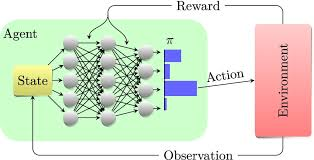

In [4]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

The DQNAgent class orchestrates the training and application of separate DQN models for each metaheuristic algorithm, allowing individual optimization of their hyperparameters. This agent interacts with the FSSPEnvironment to effectively learn and apply strategies that minimize the overall scheduling time in the Flow Shop Scheduling Problem.

In [5]:
class DQNAgent:
    def __init__(self, state_dim, action_dim_per_metaheuristic):
        self.state_dim = state_dim
        self.action_dim = action_dim_per_metaheuristic
        self.memory = deque(maxlen=2000)
        self.gamma = 0.95  # Discount factor
        self.epsilon = 1.0  # Exploration rate
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001
        self.batch_size = 64

        # Initialize models for each metaheuristic
        self.models = {
            'GA': DQN(state_dim, action_dim_per_metaheuristic),
            'SA': DQN(state_dim, action_dim_per_metaheuristic),
            'TS': DQN(state_dim, action_dim_per_metaheuristic)
        }
        self.optimizers = {
            'GA': optim.Adam(self.models['GA'].parameters(), lr=self.learning_rate),
            'SA': optim.Adam(self.models['SA'].parameters(), lr=self.learning_rate),
            'TS': optim.Adam(self.models['TS'].parameters(), lr=self.learning_rate)
        }
        self.loss_fn = nn.MSELoss()

    def act(self, state, metaheuristic):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_dim)  # Explore: random action
        state = torch.FloatTensor(state).unsqueeze(0)
        act_values = self.models[metaheuristic](state)
        # Exploit: best action according to the model
        return torch.argmax(act_values, dim=1).item()

    def remember(self, state, action, reward, next_state, done, metaheuristic):
        self.memory.append(
            (state, action, reward, next_state, done, metaheuristic))

    def replay(self, metaheuristic):
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        for state, action, reward, next_state, done, mh in minibatch:
            if mh != metaheuristic:  # Process only relevant experiences
                continue
            state = torch.FloatTensor(state).unsqueeze(0)
            next_state = torch.FloatTensor(next_state).unsqueeze(0)
            target = reward
            if not done:
                target = reward + self.gamma * \
                    torch.max(self.models[mh](next_state)).item()
            target_f = self.models[mh](state)
            target_f[0][action] = target
            loss = self.loss_fn(target_f, self.models[mh](state))
            self.optimizers[mh].zero_grad()
            loss.backward()
            self.optimizers[mh].step()

        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

## Training

### High Level Hyperparameters 
After thorough theoretical analysis and extensive testing, we have identified a set of optimal parameters for the reinforcement learning model. These parameters have been fine-tuned to achieve the best performance in training the DQN agent to solve the Flow Shop Scheduling Problem effectively. Below are the configurations that yielded the most efficient learning progress and solution quality.

In [6]:
# Number of episodes for the agent to train over. Each episode consists of a sequence of actions and rewards.
NUM_EPISODES = 300
# Discount factor for future rewards, balancing immediate and future reward importance.
gamma = 0.95
# Initial exploration rate, where 1.0 indicates 100% exploration (random actions).
epsilon = 1.0
# Minimum exploration rate, ensuring there's always some degree of exploration.
epsilon_min = 0.01
# Decay rate for epsilon, reducing exploration over time as the agent learns.
epsilon_decay = 0.995
# Learning rate for the optimizer, controlling how much the neural network weights change in response to the estimated error each batch.
learning_rate = 0.001
# Number of training examples utilized in one iteration, indicating how many experiences are used to update the network at once.
batch_size = 32

### Deep Neural Network Agent and Environment

In [7]:
# Initialize environment and agent

benchmark_instance = benchmarks[0]
jobs = benchmark_instance["data"]
machines = list(range(1,len(jobs[0])+1))
upper_bound = benchmark_instance["upper-bound"]


env = FSSPEnvironment(jobs, machines)
agent = DQNAgent(
    env.observation_space.shape[0] * env.observation_space.shape[1], env.action_space.n)

### Training

The train_agent function orchestrates the training process of the DQN agent across multiple episodes. In each episode, the agent interacts with the environment to optimize scheduling decisions based on different metaheuristics (Genetic Algorithm, Simulated Annealing, and Tabu Search). The function dynamically selects metaheuristics, executes actions, and updates the agent models based on the rewards received. This iterative process aims to minimize the makespan of the scheduling problem while allowing the agent to explore and exploit learned strategies efficiently. Scores are tracked and reported periodically, and model checkpoints are saved at regular intervals to monitor progress and facilitate model recovery and further analysis.

In [8]:
def train_agent(env, agent, n_episodes, max_timesteps_per_episode):
    # Assuming keys are 'GA', 'SA', 'TS'
    scores = {mh: [] for mh in agent.models.keys()}
    scores_window = {mh: deque(maxlen=100) for mh in agent.models.keys()}

    for episode in range(1, n_episodes + 1):
        state = env.reset()
        state = state.flatten()
        score = {mh: 0 for mh in agent.models.keys()}

        for t in range(max_timesteps_per_episode):
            metaheuristic = determine_metaheuristic(t, state, env)
            agent.current_metaheuristic = metaheuristic

            action = agent.act(state, metaheuristic)
            next_state, reward, done, info = env.step(action)
            next_state = next_state.flatten()

            agent.remember(state, action, reward,
                           next_state, done, metaheuristic)
            agent.replay(metaheuristic)

            state = next_state
            score[metaheuristic] += reward
            if done:
                break

        for mh in scores.keys():
            scores_window[mh].append(score[mh])
            scores[mh].append(score[mh])

        if episode % 100 == 0:
            print(f'\rEpisode {episode}')
            for mh in scores.keys():
                print(
                    f'\t{mh} Average Score: {np.mean(scores_window[mh]):.2f}')
                torch.save(agent.models[mh].state_dict(),
                           f'checkpoint_{mh}_{episode}.pth')

    return scores

In [9]:
def determine_metaheuristic(t, state, env):
    metaheuristics = ['GA', 'SA', 'TS']
    return np.random.choice(metaheuristics)

In [10]:
n_episodes = 200  # Total number of episodes to train
max_timesteps_per_episode = 100  # Max timesteps in one episode

scores = train_agent(env, agent, n_episodes, max_timesteps_per_episode)

Episode 100
	GA Average Score: -468.06
	SA Average Score: -511.83
	TS Average Score: -357.70
Episode 200
	GA Average Score: -454.19
	SA Average Score: -401.39
	TS Average Score: -482.14


## Evaluation

The evaluate_agent function systematically assesses the performance of a DQN agent across different metaheuristic strategies by applying them to a series of test instances in the FSSP environment. It aggregates and reports the total and average rewards for each metaheuristic, demonstrating their effectiveness in minimizing the scheduling problem's makespan.

In [17]:
import time
def evaluate_agent(agent, test_instance):
    # Initialize results for each metaheuristic
    results = {mh: {'total_reward': 0, 'makespan': 0, 'rdp': 0, 'time': 0} for mh in agent.models.keys()}

    jobs, machines, upper_bound = test_instance
    print(f"Test Instance : ")
    print(f"Upper Bound : ", upper_bound)
    print('----')
    instance_metrics = []

    for mh in agent.models.keys():  # Evaluate each metaheuristic
        env = FSSPEnvironment(jobs, machines)
        state = env.reset()
        state = state.flatten()
        done = False
        total_reward = 0

        start_time = time.time()

        while not done:
            # Use the correct metaheuristic for action selection
            action = agent.act(state, mh)
            next_state, reward, done, info = env.step(action)
            next_state = next_state.flatten()
            state = next_state
            total_reward += reward

        end_time = time.time()
        execution_time = end_time - start_time

        makespan = info['makespan']
        rdp = round((makespan - upper_bound) / upper_bound * 100, 2)

        results[mh] = {
            'rdp': rdp,
            'time': execution_time
        }

        instance_metrics.append((mh, total_reward, makespan, rdp, execution_time))
        print(f"\nMetaheuristic: {mh},\nHyperparameters: {info['hyperparameters']},\nMakespan: {makespan}, \nTotal Reward: {total_reward}")
        print(f"RDP: {rdp}%, Execution Time: {execution_time} seconds")
    print("=====================")

    return results


def draw_results(results):
    # Extract metrics from the results
    metaheuristics = list(results.keys())

    rdps = [results[mh]['rdp'] for mh in metaheuristics]
    times = [results[mh]['time'] for mh in metaheuristics]

    x = np.arange(len(metaheuristics))  # the label locations
    width = 0.2  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 8))
    rects3 = ax.bar(x + width, rdps, width, label='RDP (%)', color='salmon')
    rects4 = ax.bar(x + 2 * width, times, width,
                    label='Execution Time (s)', color='orange')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel('Metaheuristic')
    ax.set_title('Performance Metrics for Each Metaheuristic')
    ax.set_xticks(x)
    ax.set_xticklabels(metaheuristics)
    ax.legend()

    # Attach a text label above each bar in rects, displaying its height.
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{}'.format(round(height, 2)),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects3)
    autolabel(rects4)

    fig.tight_layout()
    plt.show()

### Benchmark 20_5

In [15]:

test_instances = []

jobs = benchmarks[0]["data"]
machines = list(range(1,len(jobs[0])+1))
upper_bound = benchmarks[0]["upper-bound"]
test_instances.append((jobs, machines, upper_bound))



# Initialize environment to get state and action dimensions
jobs, machines,_ = test_instances[0]
env = FSSPEnvironment(jobs, machines)
state_dim = env.observation_space.shape[0] * env.observation_space.shape[1]
action_dim = env.action_space.n

# Initialize the agent
agent = DQNAgent(state_dim, action_dim)

Test Instance : 
Upper Bound :  1278
----

Metaheuristic: GA,
Hyperparameters: {'initial_temperature': 680, 'cooling_rate': 0.88, 'final_temperature': 0.12, 'alpha': 0.9349999999999999, 'neighborhood_function': 'swap'},
Makespan: 1377, 
Total Reward: -1377
RDP: 7.75%, Execution Time: 0.008702754974365234 seconds

Metaheuristic: SA,
Hyperparameters: {'population_size': 90, 'mutation_rate': 0.08, 'crossover_rate': 0.95, 'elitism_rate': 0.15000000000000002, 'selection_type': 'roulette'},
Makespan: 1362, 
Total Reward: -1362
RDP: 6.57%, Execution Time: 2.045243740081787 seconds

Metaheuristic: TS,
Hyperparameters: {'population_size': 80, 'mutation_rate': 0.05, 'crossover_rate': 0.65, 'elitism_rate': 0.0, 'selection_type': 'tournament'},
Makespan: 1344, 
Total Reward: -1344
RDP: 5.16%, Execution Time: 1.6977360248565674 seconds


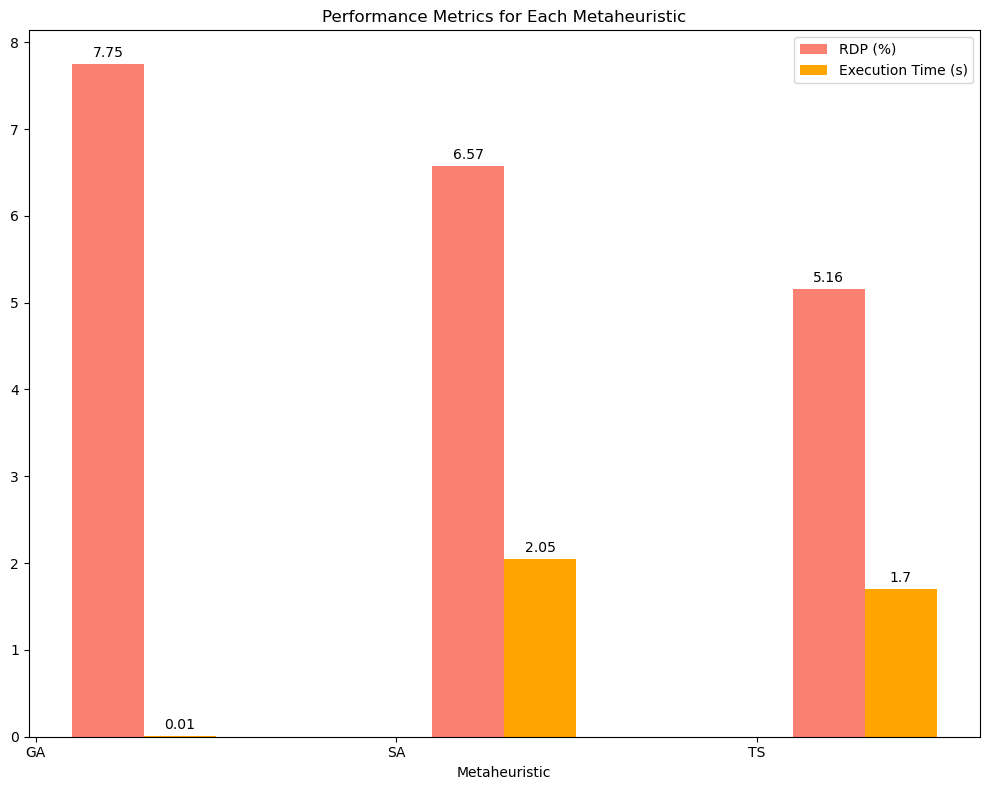

In [18]:
# Evaluate the agent
results = evaluate_agent(agent, test_instances[0])
draw_results(results)

### Benchmark 50_5

In [19]:

test_instances = []

jobs = big_benchmarks[0]["data"]
machines = list(range(1, len(jobs[0])+1))
upper_bound = big_benchmarks[0]["upper-bound"]
test_instances.append((jobs, machines, upper_bound))



# Initialize environment to get state and action dimensions
jobs, machines,_ = test_instances[0]
env = FSSPEnvironment(jobs, machines)
state_dim = env.observation_space.shape[0] * env.observation_space.shape[1]
action_dim = env.action_space.n

# Initialize the agent
agent = DQNAgent(state_dim, action_dim)

Test Instance : 
Upper Bound :  2724
----

Metaheuristic: GA,
Hyperparameters: {'tabu_list_size': 9, 'max_iterations': 240, 'neighborhood_size': 10, 'diversification_factor': 0.30000000000000004, 'intensification_factor': 0.30000000000000004},
Makespan: 2752, 
Total Reward: -2752
RDP: 1.03%, Execution Time: 0.41888952255249023 seconds

Metaheuristic: SA,
Hyperparameters: {'tabu_list_size': 7, 'max_iterations': 160, 'neighborhood_size': 20, 'diversification_factor': 0.1, 'intensification_factor': 0.1},
Makespan: 2729, 
Total Reward: -2729
RDP: 0.18%, Execution Time: 0.585517406463623 seconds

Metaheuristic: TS,
Hyperparameters: {'population_size': 50, 'mutation_rate': 0.08, 'crossover_rate': 1.15, 'elitism_rate': 0.15000000000000002, 'selection_type': 'roulette'},
Makespan: 2775, 
Total Reward: -2775
RDP: 1.87%, Execution Time: 2.589475393295288 seconds


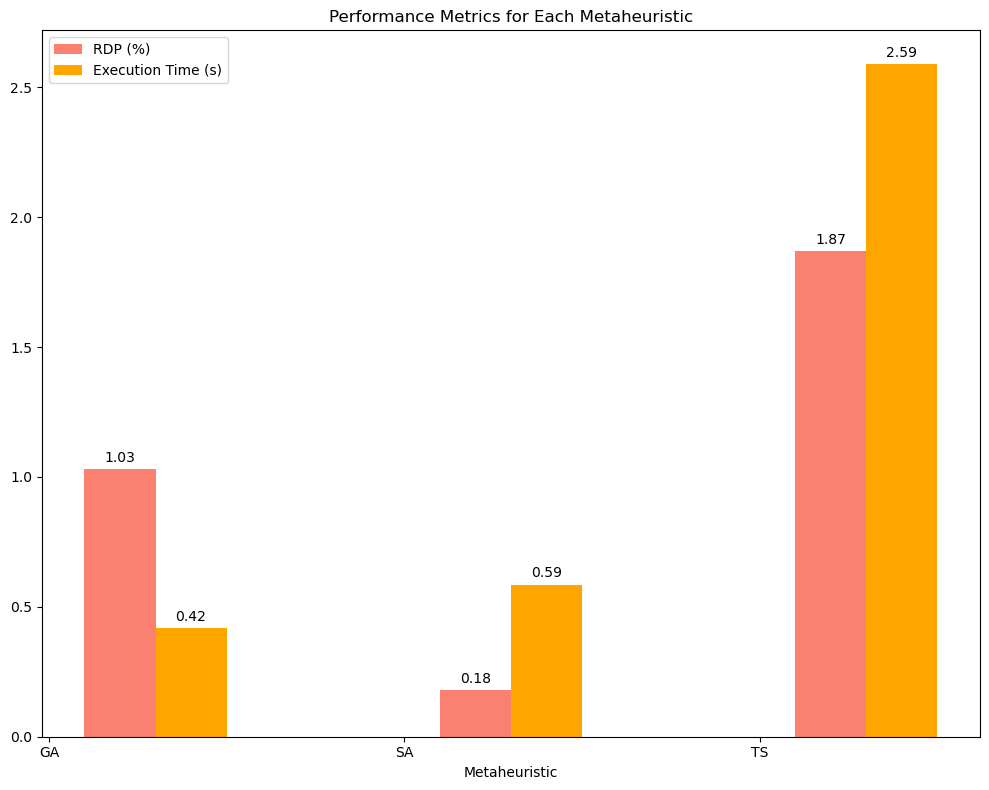

In [20]:
# Evaluate the agent
results = evaluate_agent(agent, test_instances[0])
draw_results(results)

### Benchmark 100_5

In [21]:

test_instances = []

jobs = big_benchmarks[1]["data"]
machines = list(range(1, len(jobs[0])+1))
upper_bound = big_benchmarks[1]["upper-bound"]
test_instances.append((jobs, machines, upper_bound))


# Initialize environment to get state and action dimensions
jobs, machines,_ = test_instances[0]
env = FSSPEnvironment(jobs, machines)
state_dim = env.observation_space.shape[0] * env.observation_space.shape[1]
action_dim = env.action_space.n

# Initialize the agent
agent = DQNAgent(state_dim, action_dim)

Test Instance : 
Upper Bound :  5493
----

Metaheuristic: GA,
Hyperparameters: {'population_size': 90, 'mutation_rate': 0.060000000000000005, 'crossover_rate': 0.65, 'elitism_rate': 0.05, 'selection_type': 'roulette'},
Makespan: 6074, 
Total Reward: -6074
RDP: 10.58%, Execution Time: 5.603201866149902 seconds

Metaheuristic: SA,
Hyperparameters: {'initial_temperature': 260, 'cooling_rate': 0.86, 'final_temperature': 0.04, 'alpha': 0.945, 'neighborhood_function': 'swap'},
Makespan: 5687, 
Total Reward: -5687
RDP: 3.53%, Execution Time: 0.0178375244140625 seconds

Metaheuristic: TS,
Hyperparameters: {'population_size': 90, 'mutation_rate': 0.05, 'crossover_rate': 1.0, 'elitism_rate': 0.0, 'selection_type': 'tournament'},
Makespan: 5769, 
Total Reward: -5769
RDP: 5.02%, Execution Time: 5.991169214248657 seconds


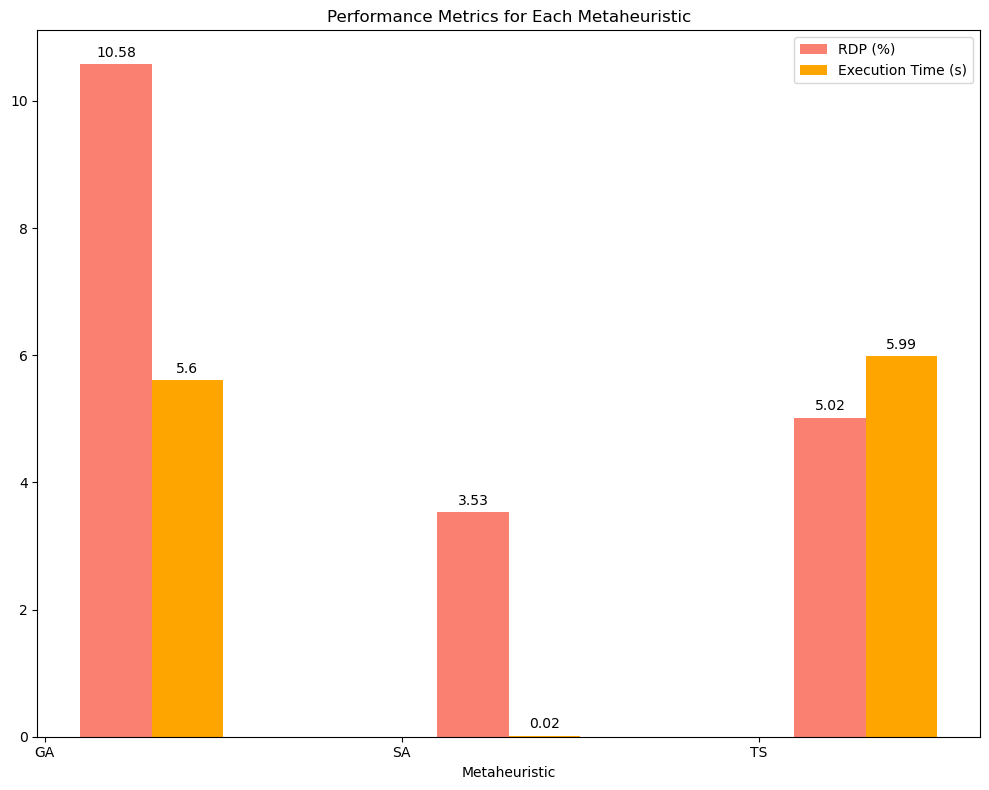

In [22]:
# Evaluate the agent
results = evaluate_agent(agent, test_instances[0])
draw_results(results)

### Benchmark 200_10

In [23]:

test_instances = []
jobs = big_benchmarks[2]["data"]
machines = list(range(1, len(jobs[0])+1))
upper_bound = big_benchmarks[2]["upper-bound"]
test_instances.append((jobs, machines, upper_bound))


# Initialize environment to get state and action dimensions
jobs, machines,_ = test_instances[0]
env = FSSPEnvironment(jobs, machines)
state_dim = env.observation_space.shape[0] * env.observation_space.shape[1]
action_dim = env.action_space.n

# Initialize the agent
agent = DQNAgent(state_dim, action_dim)

Test Instance : 
Upper Bound :  10868
----

Metaheuristic: GA,
Hyperparameters: {'initial_temperature': 680, 'cooling_rate': 0.88, 'final_temperature': 0.12, 'alpha': 0.9349999999999999, 'neighborhood_function': 'swap'},
Makespan: 11888, 
Total Reward: -11888
RDP: 9.39%, Execution Time: 0.0814967155456543 seconds

Metaheuristic: SA,
Hyperparameters: {'initial_temperature': 220, 'cooling_rate': 0.87, 'final_temperature': 0.03, 'alpha': 0.94, 'neighborhood_function': 'swap'},
Makespan: 11873, 
Total Reward: -11873
RDP: 9.25%, Execution Time: 0.07295107841491699 seconds

Metaheuristic: TS,
Hyperparameters: {'tabu_list_size': 7, 'max_iterations': 200, 'neighborhood_size': 10, 'diversification_factor': 0.30000000000000004, 'intensification_factor': 0.30000000000000004},
Makespan: 11576, 
Total Reward: -11576
RDP: 6.51%, Execution Time: 2.0976150035858154 seconds


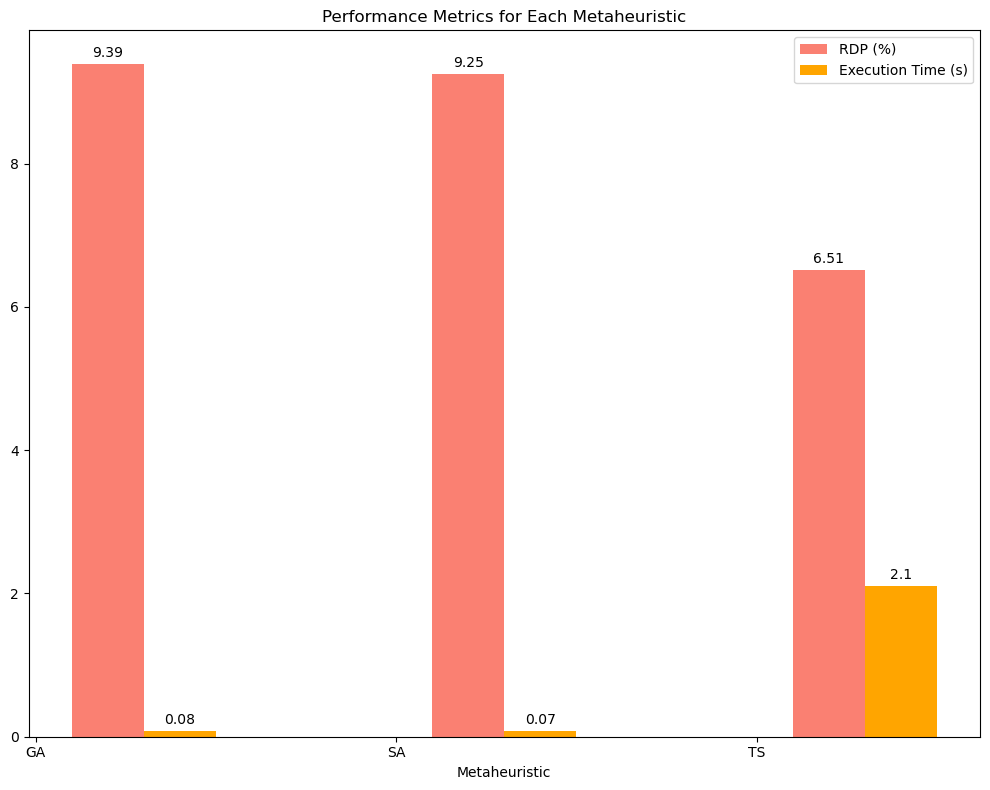

In [24]:
# Evaluate the agent
results = evaluate_agent(agent, test_instances[0])
draw_results(results)

### Benchmark 500_20

In [25]:

test_instances = []
jobs = big_benchmarks[3]["data"]
machines = list(range(1, len(jobs[0])+1))
upper_bound = big_benchmarks[3]["upper-bound"]
test_instances.append((jobs, machines, upper_bound))


# Initialize environment to get state and action dimensions
jobs, machines, _ = test_instances[0]
env = FSSPEnvironment(jobs, machines)
state_dim = env.observation_space.shape[0] * env.observation_space.shape[1]
action_dim = env.action_space.n

# Initialize the agent
agent = DQNAgent(state_dim, action_dim)

Test Instance : 
Upper Bound :  26189
----

Metaheuristic: GA,
Hyperparameters: {'tabu_list_size': 9, 'max_iterations': 120, 'neighborhood_size': 10, 'diversification_factor': 0.1, 'intensification_factor': 0.1},
Makespan: 29026, 
Total Reward: -29026
RDP: 10.83%, Execution Time: 6.6478636264801025 seconds

Metaheuristic: SA,
Hyperparameters: {'tabu_list_size': 7, 'max_iterations': 280, 'neighborhood_size': 20, 'diversification_factor': 0.30000000000000004, 'intensification_factor': 0.30000000000000004},
Makespan: 28873, 
Total Reward: -28873
RDP: 10.25%, Execution Time: 31.34934711456299 seconds

Metaheuristic: TS,
Hyperparameters: {'initial_temperature': 580, 'cooling_rate': 0.88, 'final_temperature': 0.09999999999999999, 'alpha': 0.9349999999999999, 'neighborhood_function': 'swap'},
Makespan: 29353, 
Total Reward: -29353
RDP: 12.08%, Execution Time: 0.39799070358276367 seconds


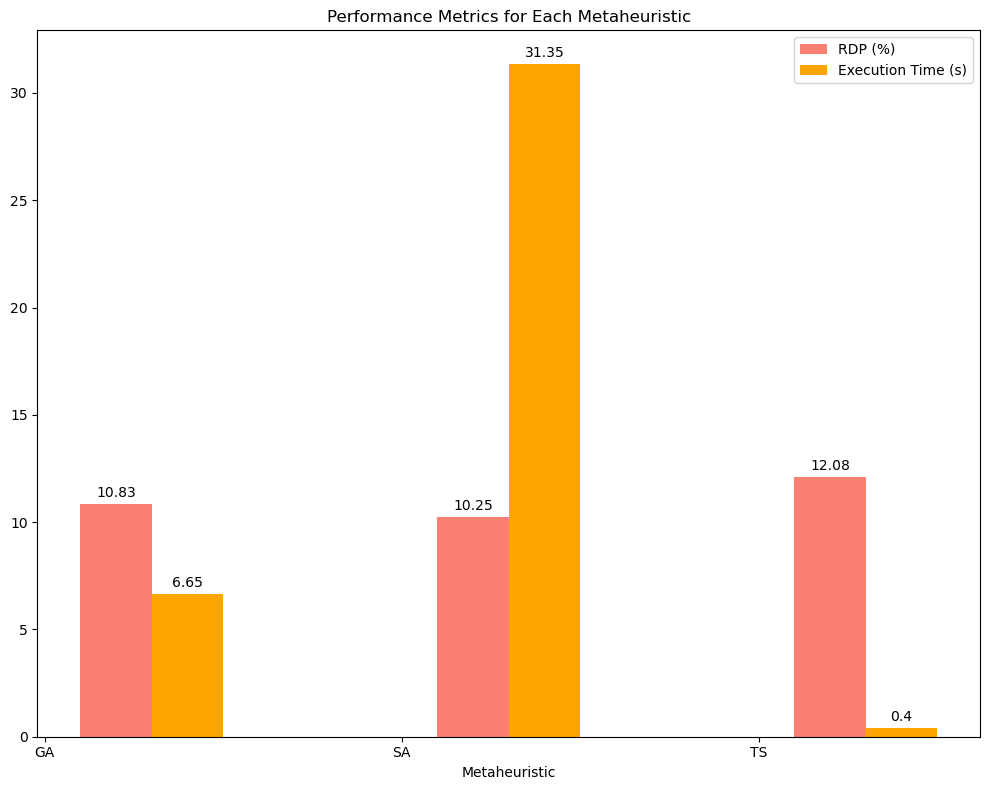

In [26]:
# Evaluate the agent
results = evaluate_agent(agent, test_instances[0])
draw_results(results)

## Conclusion

In this notebook, we explored an innovative approach by combining reinforcement learning with metaheuristic methods to solve the Flow Shop Scheduling Problem (FSSP). By using a Deep Q-Network (DQN) to optimize the hyperparameters of various metaheuristics, we demonstrated that this method can effectively reduce the makespan, thus improving scheduling efficiency. The results obtained not only illustrate the viability of the reinforcement learning approach in complex optimization contexts but also open new avenues for future research, aiming to further refine performance and explore other combinations of metaheuristic and machine learning techniques.